In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from scipy.stats import poisson, uniform, expon, pareto
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

In [29]:
def honestBlocksBernoulli(a_, b_, g_, p_, C_, E_):
    expr1 = (1-a_)/(a_*p_*(1-np.min([1,np.exp(-b_+C_+E_)]))+a_*(1-p_)*(1-np.exp(-b_+C_)))
    expr2 = expr1 + (2*(1-a_)*(1-g_)+g_*(1-a_))*(1-a_) + a_*(1-a_)
    return expr2

def attackBlocksBernoulli(a_, b_, g_, p_, C_, E_):
    num   = a_*p_*np.min([1,np.exp(-b_+C_+E_)])+a_*(1-p_)*np.exp(-b_+C_)
    den   = a_*p_*(1-np.min([1,np.exp(-b_+C_+E_)]))+a_*(1-p_)*(1-np.exp(-b_+C_))
    expr1 = num / den
    expr2 = (a_**3) / ((1-2*a_)*(1-a_))
    expr3 = expr1 + (2*a_ + g_*(1-a_))*(1-a_) + a_**2 + a_*(2-a_)/(1-a_) + expr2
    return expr3

def fixRewTheo(a_, b_, g_, p_, C_, E_):
    A = attackBlocksBernoulli(a_, b_, g_, p_, C_, E_)
    H = honestBlocksBernoulli(a_, b_, g_, p_, C_, E_)
    return A/(A+H)

In [71]:
theoRes = []
for a in alphas:
    temp1 = []
    for b in betas:
        temp2 = []
        for p in ps:
#             temp2.append(attackBlocksBernoulli(a=a, b=b, g=0.0, p=p, E=1., C=1.))
            temp2.append(fixRewTheo(a=a, b=b, g=0.0, p=p, E=1., C=1.))
        temp1.append(temp2)
    theoRes.append(temp1)
theoRes = np.array(theoRes)
theoRes.shape

(5, 225, 3)

In [7]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [186]:
# ps should be the same
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [4]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

NameError: name 'sp' is not defined

In [189]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [192]:
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [193]:
f0i   = C * (a*p*sp.Min(1,sp.exp(-b+C+E)) + a*(1-p)*sp.exp(-b+C))
f0ii  = a*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii = (1-a)*(a+g*(1-a))*C * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C)))
f0iii

C*(1 - a)*(a + g*(1 - a))*(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b)))

In [194]:
f0   = f0i + f0ii + f0iii
f1   = C*(a+(1-a)*a)

In [169]:
# DONT NEED
f1   = a + a*(1-a)
f2   = a + a*(1-a)
f3   = a + a*(1-a) + a*(1-a)**2
f4   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3

In [203]:
full  = p0*f0 + p1*f1 + C*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
final = sp.simplify(full.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
final

a*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(1.0*a*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 1.0*a*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + 1.0*p*exp(b)*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p + 2.71828182845905))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.1226

In [204]:
finalLambda = sp.lambdify((a, b, p), final)
finalLambda

<function _lambdifygenerated(a, b, p)>

In [206]:
g0   = C*(1-a)
g1   = C*(1-a)*(1-a)*(1-g)
g0p  = C*(1-a)
g0pp = C*(1-a)

In [207]:
gull = p0*g0 + p1*g1 + p0p*g0p + p0pp*g0pp
ginal = gull.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
ginal

1.0*a**2*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*ex

In [208]:
ginalLambda = sp.lambdify((a, b, p), ginal)
ginalLambda

<function _lambdifygenerated(a, b, p)>

In [209]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
newbs     = np.arange(1.751, 4, 0.1)
newbs

array([1.751, 1.851, 1.951, 2.051, 2.151, 2.251, 2.351, 2.451, 2.551,
       2.651, 2.751, 2.851, 2.951, 3.051, 3.151, 3.251, 3.351, 3.451,
       3.551, 3.651, 3.751, 3.851, 3.951])

In [210]:
test  = finalLambda(a=0.3, b=1, p=0.5)
test2 = ginalLambda(a=0.3, b=1, p=0.5)
test+test2

2.568181818181816

In [211]:
newRes = []
for a_ in alphas:
    temp1 = []
    for b_ in newbs:
        temp2 = []
        for p_ in ps:
            attack = finalLambda(a=a_, b=b_, p=p_)
            honest = ginalLambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    newRes.append(temp1)
newRes = np.array(newRes)
newRes.shape

(5, 23, 3)

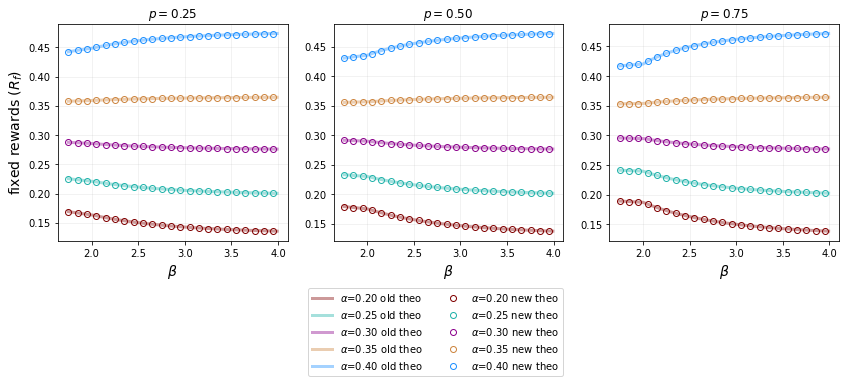

In [222]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, theoRes[j,:,i], linewidth=3, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} old theo'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} old theo'.format(a_))

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(newbs, newRes[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} new theo'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} new theo'.format(a_))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'fixed rewards ($R_f)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [219]:
def NEW(a_, b_, p_):
    attack = finalLambda(a=a_, b=b_, p=p_)
    honest = ginalLambda(a=a_, b=b_, p=p_)
    return attack/(attack+honest)

def OLD(a_, b_, p_):
    return fixRewTheo(a_=a_, b_=b_, g_=0.0, p_=p_, E_=1., C_=1.)

In [221]:
NEW(0.3, 2., 0.5) - OLD(0.3, 2., 0.5)

1.1102230246251565e-16

# BERNOULLI rewards

In [26]:
def honestExtrasBernoulli(a_, b_, g_, p_, C_, E_):
    return honestBlocksBernoulli(a_, b_, g_, p_, C_, E_)

def attackExtrasBernoulli(a_, b_, g_, p_, C_, E_):
    num   = np.min([1,np.exp(-b_+C_+E_)]) + (1-np.exp(-b_+C_+E_))*(1-((1-a_)**2*(1-g_)))
    den   = (1-p_)*(1-np.exp(-b_+C_)) + p_*(1-np.min([1,np.exp(-b_+C_+E_)]))
    expr1 = num / den
    expr2 = (a_**3) / ((1-2*a_)*(1-a_))
    expr3 = expr1 + (a_+(1-a_)*g_)*(1-a_) + a_**2 + a_/(1-a_) + expr2
    return expr3

def berRewTheo(a_, b_, g_, p_, C_, E_):
    if p_ == 0: 
        return 0
    A = attackExtrasBernoulli(a_, b_, g_, p_, C_, E_)
    H = honestExtrasBernoulli(a_, b_, g_, p_, C_, E_)
    return A/(A+H)

In [30]:
berTheoRes = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            temp2.append(berRewTheo(a_=a_, b_=b_, g_=0.0, p_=p_, C_=1., E_=1.))
        temp1.append(temp2)
    berTheoRes.append(temp1)
berTheoRes = np.array(berTheoRes)
berTheoRes.shape

(5, 225, 3)

# path counting bernoulli

In [179]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [180]:
# ps should be the same
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [181]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [182]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [183]:
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [185]:
f0i   = E * (a*p*sp.Min(1,sp.exp(-b+C+E)))
f0ii  = a*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii = (1-a)*(a+g*(1-a))*E * (a*p*(1-sp.Min(1,sp.exp(-b+C+E))))
f0iii

E*a*p*(1 - a)*(1 - Min(1, exp(C + E - b)))*(a + g*(1 - a))

In [186]:
f0   = f0i + f0ii + f0iii
f1   = p*E*(a+(1-a)*a)

In [41]:
# DONT NEED
f1   = a + a*(1-a)
f2   = a + a*(1-a)
f3   = a + a*(1-a) + a*(1-a)**2
f4   = a + a*(1-a) + a*(1-a)**2 + a*(1-a)**3

In [187]:
full  = p0*f0 + p1*f1 + p*E*p1*a*(2*a*(1-a)/(1-2*a))
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
final = sp.simplify(full.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
final

a*p*(0.245252960780962*a**2*(a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*a*(a - 2.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - 0.122626480390481*(2.0*a - 1.0)*(a*(a - 1.0)*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) - a*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0) + Min(1.0, 7.38905609893065*exp(-b)))*exp(b))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.122626480390481*(3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) - 3.0*a**2 - 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b)))

In [188]:
finalLambda = sp.lambdify((a, b, p), final)
finalLambda

<function _lambdifygenerated(a, b, p)>

In [189]:
g0   = p*E*(1-a)
g1   = p*E*(1-a)*(1-a)*(1-g)
g0p  = p*E*(1-a)
g0pp = p*E*(1-a)

In [190]:
gull = p0*g0 + p1*g1 + p0p*g0p + p0pp*g0pp
ginal = gull.evalf(subs={p1:p1_ev, C:1., E:1., g:0})
ginal

1.0*a**2*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 2.0*a*p*(1.0 - a)**2*(-2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) + 5.43656365691809*a*p*exp(-b) + 2.0*a - 5.43656365691809*a*exp(-b) + p*Min(1.0, 7.38905609893065*exp(-b)) - 2.71828182845905*p*exp(-b) - 1.0 + 2.71828182845905*exp(-b))/(-3.0*a**2*p*Min(1.0, 7.38905609893065*exp(-b)) + 8.15484548537714*a**2*p*exp(-b) + 3.0*a**2 - 8.15484548537714*a**2*exp(-b) + 2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 5.43656365691809*a*p*exp(-b) + 5.43656365691809*a*exp(-b) - 1.0) + 1.0*a*p*(1.0 - a)*(-2.0*a*p*Min(1.0, 7.38905609893

In [191]:
ginalLambda = sp.lambdify((a, b, p), ginal)
ginalLambda

<function _lambdifygenerated(a, b, p)>

In [192]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
newbs     = np.arange(1.751, 4, 0.1)
newbs

array([1.751, 1.851, 1.951, 2.051, 2.151, 2.251, 2.351, 2.451, 2.551,
       2.651, 2.751, 2.851, 2.951, 3.051, 3.151, 3.251, 3.351, 3.451,
       3.551, 3.651, 3.751, 3.851, 3.951])

In [193]:
test  = finalLambda(a=0.3, b=1, p=0.5)
test2 = ginalLambda(a=0.3, b=1, p=0.5)
test+test2

1.2840909090909078

In [194]:
newResBern = []
for a_ in alphas:
    temp1 = []
    for b_ in newbs:
        temp2 = []
        for p_ in ps:
            attack = finalLambda(a=a_, b=b_, p=p_)
            honest = ginalLambda(a=a_, b=b_, p=p_)
            temp2.append(attack/(attack+honest))
        temp1.append(temp2)
    newResBern.append(temp1)
newResBern = np.array(newResBern)
newResBern.shape

(5, 23, 3)

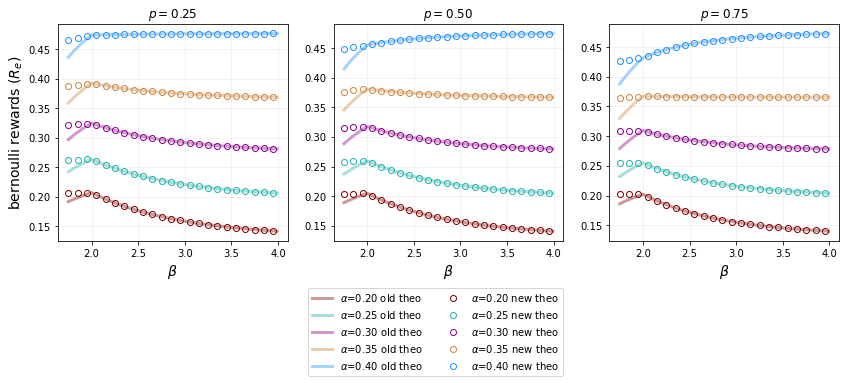

In [195]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, berTheoRes[j,:,i], linewidth=3, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} old theo'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} old theo'.format(a_))

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(newbs, newResBern[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} new theo'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} new theo'.format(a_))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'bernoulli rewards ($R_e)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [63]:
def NEW_BER(a_, b_, p_):
    attack = finalLambda(a=a_, b=b_, p=p_)
    honest = ginalLambda(a=a_, b=b_, p=p_)
    return attack/(attack+honest)

def OLD_BER(a_, b_, p_):
    return berRewTheo(a_=a_, b_=b_, g_=0.0, p_=p_, E_=1., C_=1.)

In [80]:
NEW_BER(0.3, 1.76, 0.5) - OLD_BER(0.3, 1.76, 0.5)

-1.6653345369377348e-16

# LINEAR REWARDS

In [359]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('alpha beta x gamma p C E')

In [374]:
p0fail = (1-p)*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+C+E)))+a*(1-p)*(1-sp.exp(-b+C)))
p0fail

p_1*(1 - p)*exp(-x)/(alpha*p*(1 - Min(1, exp(C + E - beta))) + alpha*(1 - p)*(1 - exp(C - beta)))

In [375]:
f0failHi = a
f0failLo = a*sp.exp(-b+C+x)+a**2*(1-sp.exp(-b+C+x)) + a*(1-a)*(1-sp.exp(-b+C+x))*(a+(1-a)*g)
f0failLo

alpha**2*(1 - exp(C - beta + x)) + alpha*(1 - alpha)*(1 - exp(C - beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(C - beta + x)

In [376]:
loIntegrandFail = sp.simplify(p0fail * f0failLo)
loIntegralFail  = sp.simplify(sp.integrate(loIntegrandFail, (x, 0, b-C)))

In [377]:
hiIntegrandFail = sp.simplify(p0fail * f0failHi)
hiIntegralFail  = sp.simplify(sp.integrate(hiIntegrandFail, (x, b-C, sp.oo)))

In [378]:
p0success = p*p1*sp.exp(-x) / (a*p*(1-sp.Min(1,sp.exp(-b+C+E)))+a*(1-p)*(1-sp.exp(-b+C)))
p0success

p*p_1*exp(-x)/(alpha*p*(1 - Min(1, exp(C + E - beta))) + alpha*(1 - p)*(1 - exp(C - beta)))

In [379]:
f0successHi = a
f0successLo = a*sp.exp(-b+C+E+x)+a**2*(1-sp.exp(-b+C+E+x)) + a*(1-a)*(1-sp.exp(-b+C+E+x))*(a+(1-a)*g)
f0successLo

alpha**2*(1 - exp(C + E - beta + x)) + alpha*(1 - alpha)*(1 - exp(C + E - beta + x))*(alpha + gamma*(1 - alpha)) + alpha*exp(C + E - beta + x)

In [380]:
loIntegrandSuccess = sp.simplify(p0success * f0successLo)
loIntegralSuccess  = sp.simplify(sp.integrate(loIntegrandSuccess, (x, 0, sp.Max(0,b-C-E))))

In [381]:
hiIntegrandSuccess = sp.simplify(p0success * f0successHi)
hiIntegralSuccess  = sp.simplify(sp.integrate(hiIntegrandSuccess, (x, sp.Max(0,b-C-E), sp.oo)))

In [382]:
full_old = loIntegralFail + hiIntegralFail + loIntegralSuccess + hiIntegralSuccess + p1*(3*a - a**2 + 2*a**2/(1-2*a))
full_old

p_1*(-alpha**2 + 2*alpha**2/(1 - 2*alpha) + 3*alpha) + Piecewise((p_1*(-alpha**2*gamma*exp(beta) + alpha**2*exp(beta) + 2*alpha*gamma*exp(beta) - 2*alpha*exp(beta) - gamma*exp(beta) - (C - beta)*(alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(C) + (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(C))/(exp(C) - exp(beta)), (exp(C + E - beta) >= 1) & Ne(exp(C) - exp(beta), 0)), (p_1*(C - beta)*((alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma)*exp(beta) - (alpha**2*gamma - alpha**2 - 2*alpha*gamma + 2*alpha + gamma - 1)*exp(C))/(exp(C) - exp(beta)), (exp(C + E - beta) >= 1) | ((exp(C + E - beta) >= 1) & Ne(p*exp(C) - p*exp(C + E) - exp(C) + exp(beta), 0))), (p_1*(alpha**2*gamma*p*exp(beta) - alpha**2*gamma*exp(beta) - alpha**2*p*exp(beta) + alpha**2*exp(beta) - 2*alpha*gamma*p*exp(beta) + 2*alpha*gamma*exp(beta) + 2*alpha*p*exp(beta) - 2*alpha*exp(beta) + gamma*p*exp(beta) - gamma*exp(beta) + (C - beta)*(alpha**2*gamma*p - alpha**2*gamma 

In [383]:
p1_solved = 1/(1/(a*p*(1-sp.Min(1,sp.exp(-b+C+E))) + a*(1-p)*(1-sp.exp(-b+C))) + 1 + (1-a)/(1-2*a))
p1_solved

1/(1 + 1/(alpha*p*(1 - Min(1, exp(C + E - beta))) + alpha*(1 - p)*(1 - exp(C - beta))) + (1 - alpha)/(1 - 2*alpha))

In [384]:
full_old_lambda = sp.lambdify((a, b, g, p, C, E), full_old.evalf(subs={p1:p1_solved}))
full_old_lambda

<function _lambdifygenerated(alpha, beta, gamma, p, C, E)>

In [385]:
alphas    = [0.2, 0.25, 0.3, 0.35, 0.4]
betas     = np.arange(1.751, 4, 0.01)
ps        = [0.25, 0.5, 0.75] # using E=1, C=1
newbs     = np.arange(1.751, 4, 0.1)
newbs

array([1.751, 1.851, 1.951, 2.051, 2.151, 2.251, 2.351, 2.451, 2.551,
       2.651, 2.751, 2.851, 2.951, 3.051, 3.151, 3.251, 3.351, 3.451,
       3.551, 3.651, 3.751, 3.851, 3.951])

In [386]:
linTheoRes = []
for a_ in alphas:
    temp1 = []
    for b_ in betas:
        temp2 = []
        for p_ in ps:
            temp2.append(full_old_lambda(alpha=a_, beta=b_, gamma=0.0, p=p_, C=1., E=1.))
        temp1.append(temp2)
    linTheoRes.append(temp1)
linTheoRes = np.array(linTheoRes)
linTheoRes.shape

(5, 225, 3)

# path counting linear

In [341]:
p0, p0p, p1, p0pp = sp.symbols('p_0 p_{00} p_1 p_{000}')
a, b, x, g, p, C, E  = sp.symbols('a b x g p C E')

In [342]:
# ps should be the same
p0    = p1 / (a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1)))
p0p   = p1 * (1-a)
p0pp  = p1 * a
p2    = p1*(a/(1-a))
prest = p1*a/(1-2*a)

In [343]:
eq = sp.Eq(p0+p0p+p0pp+prest+p1, 1)
p1_sym = sp.solve(eq, p1)[0]

In [344]:
p1_me = (1/(a*(1-p)*(1-sp.exp(-b+C)) + a*p*(1-sp.Min(sp.exp(-b+C+E),1))) + 1 + (1-a)/(1-2*a))**(-1)
p1_me

1/(1 + 1/(a*p*(1 - Min(1, exp(C + E - b))) + a*(1 - p)*(1 - exp(C - b))) + (1 - a)/(1 - 2*a))

In [345]:
p1_sym.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1}), p1_me.evalf(subs={a:0.3, b:3, p:0.5, C:1, E:1})

(0.138811963706275, 0.138811963706275)

In [353]:
f0i   = a*p*(b-C-E+1)*sp.exp(-b+C+E) + a*(1-p)*(b-C+1)*sp.exp(-b+C)
f0ii  = a* (a*p*(1-(b-C-E+1)*sp.exp(-b+C+E)) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C))) 
f0iii = ((1-a)*(a+g*(1-a)))* (a*p*(1-(b-C-E+1)*sp.exp(-b+C+E)) + a*(1-p)*(1-(b-C+1)*sp.exp(-b+C)))
f0iii

(1 - a)*(a + g*(1 - a))*(a*p*(-(-C - E + b + 1)*exp(C + E - b) + 1) + a*(1 - p)*(-(-C + b + 1)*exp(C - b) + 1))

In [352]:
f0iii.evalf(subs={p:0, C:0.})

a*(1.0 - a)*(a + g*(1.0 - a))*(-(b + 1.0)*exp(-b) + 1.0)

In [354]:
f0 = f0i + f0ii + f0iii
f1 = a + 2*a*(1-a)

In [355]:
full = p0*f0 + p1*f1 + p1*a*a*(3-2*a)/(1-2*a)
p1_ev = p1_sym.evalf(subs={C:1., E:1.})
final = sp.simplify(full.evalf(subs={p1:p1_ev, C:1., E:1., g:0}))
final

0.122626480390481*a*(a**2*(2.0*a - 3.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) - a*(2.0*a - 3.0)*(2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905)) + (2.0*a - 1.0)*(-a*(a - 1.0)*(p*(7.38905609893065*b - 1.0*exp(b) - 7.38905609893065) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + a*(p*(7.38905609893065*b - 1.0*exp(b) - 7.38905609893065) - (2.71828182845905*b - 1.0*exp(b))*(p - 1.0)) + 2.71828182845905*b*(p - 1.0) - 7.38905609893065*p*(b - 1.0)))*(-5.43656365691809*a*p + 5.43656365691809*a + 2.71828182845905*p + (2.0*a*p*Min(1.0, 7.38905609893065*exp(-b)) - 2.0*a - p*Min(1.0, 7.38905609893065*exp(-b)) + 1.0)*exp(b) - 2.71828182845905)/((2.0*a - 1.0)*(p*(Min(1.0, 7.38905609893065*exp(-b)) - 1.0)*exp(b) + (p - 1.0)*(1.0*exp(b) - 2.71828182845905))*(-a**2*p + a**2 + 0.666666666666667*a*p - 0.666666666666667*a + 0.122626480390481*(3.0*a**2*p*Min(1.0, 7.38905609893065*exp

In [356]:
finalLambda = sp.lambdify((a, b, p), final)
finalLambda

<function _lambdifygenerated(a, b, p)>

In [357]:
newResLin = []
for a_ in alphas:
    temp1 = []
    for b_ in newbs:
        temp2 = []
        for p_ in ps:
            attack = finalLambda(a=a_, b=b_, p=p_)
            temp2.append(attack)
        temp1.append(temp2)
    newResLin.append(temp1)
newResLin = np.array(newResLin)
newResLin.shape

(5, 23, 3)

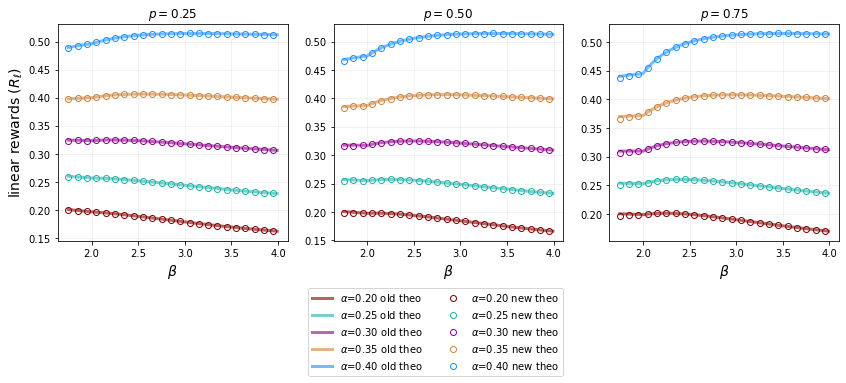

In [387]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, linTheoRes[j,:,i], linewidth=3, color=colors[j], alpha=0.6,
                        label=r'$\alpha$={:0.2f} old theo'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} old theo'.format(a_))

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(newbs, newResLin[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} new theo'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} new theo'.format(a_))


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'linear rewards ($R_\ell)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [403]:
a_ = 0.3
b_ = 4.2
p_ = 0.5
finalLambda(a_, b_, p_) - full_old_lambda(alpha=a_, beta=b_, gamma=0.0, p=p_, C=1., E=1.)

5.551115123125783e-17

In [1]:
# BERNOULLI debug

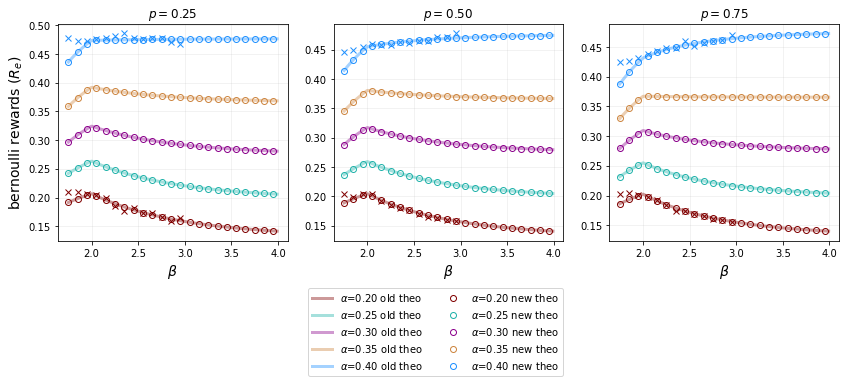

In [177]:
f, axarr = plt.subplots(ncols=3, figsize=(14,4))

colors = ['maroon', 'lightseagreen', 'darkmagenta', 'peru', 'dodgerblue'] 
handles, labels = [], []

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        line, = ax.plot(betas, berTheoRes[j,:,i], linewidth=3, color=colors[j], alpha=0.4,
                        label=r'$\alpha$={:0.2f} old theo'.format(a_))
        if i == 0:
            handles.append(line)
            labels.append(r'$\alpha$={:0.2f} old theo'.format(a_))

for i in range(3):
    ax = axarr[i]
    for j, a_ in enumerate(alphas):
        marker, = ax.plot(newbs, newResBern[j,:,i], marker='o', color=colors[j], linestyle='none', 
                          fillstyle='none', label=r'$\alpha$={:0.2f} new theo'.format(a_))
        if i == 0:
            handles.append(marker)
            labels.append(r'$\alpha$={:0.2f} new theo'.format(a_))
    marker, = ax.plot(simBetas, simsRes[0,:,i], marker='x', color=colors[0], linestyle='none', 
                      fillstyle='none')
    marker, = ax.plot(simBetas, simsRes[1,:,i], marker='x', color=colors[-1], linestyle='none', 
                      fillstyle='none')
    


for i, ax in enumerate(axarr):
    ax.grid(alpha=0.2)
    ax.set_xlabel(r'$\beta$', size=14)
    ax.set_title(r'$p=${:0.2f}'.format(ps[i]))

axarr[0].set_ylabel(r'bernoulli rewards ($R_e)$', size=14)
f.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)

plt.savefig('out.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [129]:
simBetas  = np.arange(1.75, 3., 0.1)
simBetas

array([1.75, 1.85, 1.95, 2.05, 2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75,
       2.85, 2.95])

In [176]:
simsRes = []
for a in [alphas[0],alphas[-1]]:
    temp1 = []
    for b in tqdm(simBetas):
        temp2 = []
        for p in ps:
            honestBer, attackBer= simAllRews(a=a, b=b, p=p, C=1, E=1, n=int(5e4))
            temp2.append(attackBer/(attackBer+honestBer))
        temp1.append(temp2)
    simsRes.append(temp1)
simsRes = np.array(simsRes)
simsRes.shape

100%|██████████| 13/13 [00:11<00:00,  1.10it/s]


(2, 13, 3)

In [178]:
# simluation code
def simAllRews(a, b, p, C, E, n):
    gamma = 0
    state = [0,0] # (attacker, honest)

    honestBern = 0
    attackBern = 0
    prevBern   = 0
    for _ in range(n):
        time = np.random.exponential()
        attBlock = np.random.binomial(1, a)
        bernRews = np.random.binomial(1, p=p)
        if state == [0,0]:
            if attBlock:
                if bernRews and (time < np.max([b-C-E,0])):
                    state      = [1,0]
                    prevBern   = bernRews
                elif not bernRews and time < (b-C):
                    state      = [1,0]
                    prevBern   = 0
                else:
                    attackBern += bernRews
                    prevBern   = bernRews
            else:
                honestBern += bernRews
                prevBern   = bernRews
            continue

        if state == [1,0]:
            if attBlock:
                state = [2,0]
                attackBern += bernRews + prevBern
                prevBern   = 0
            else:
                sample        = np.random.uniform()
                nextBern      = np.random.binomial(1, p=p)
                if sample < a:
                    attackBern += (prevBern + nextBern)
                elif sample <= a + ((1-a)*gamma):
                    attackBern += prevBern
                    honestBern += nextBern
                else:
                    # honest bern is a random trial
                    prevHonest  = np.random.binomial(1, p=p)
                    honestBern += (prevHonest + nextBern)
                prevBern    = 0
                state = [0,0]
            continue

        if attBlock:
            state[0] += 1
        else:
            state[1] += 1

        diff = state[0] - state[1]
        if diff == 1:
            if state[0] < 2:
                raise KeyError("here")
            attackBern += (state[0]-2) * p * E

            # 0'' state
            attBlock = np.random.binomial(1, a)
            bernRews = np.random.binomial(1, p=p)
            if attBlock:
                attackBern += bernRews
            else:
                honestBern += bernRews
            state = [0,0]
    return honestBern, attackBern